# Drifter Trajectory Plotting

This notebook demonstrates a simple plotting exercise for drifter trajectory data, using the output of a VirtualShip expedition. There are example plots embedded in this notebook, but these will ultimately be replaced by your own versions if you are working through the notebook with your own expedition output.

The plots we will produce are simple plots which visualise the trajectories of the drifters released at each waypoint of the VirtualShip expedition. We will also have a look at adding the sea surface temperature recorded by the drifters as they move through the ocean. Finally, the notebook will conclude with some example questions that you can think about as you interpret the drifter trajectories, using the Agulhas region as a case study.

## Set up

#### Imports

The first step is to import the Python packages required for post-processing the data and plotting. 

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> You may need to set the Kernel to the relevant (Conda) environment in the top right of this notebook to access the required packages! 
</div>

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

#### Data directory

Next, you should set `data_dir` to be the path to your expedition results in the code block below. You should replace `"/path/to/EXPEDITION/results/"` with the path for your machine.

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> You can get the path to your expedition results by navigating to the `results` folder in Terminal (using `cd`) and then using the `pwd` command. This will print your working directory which you can copy to the `data_dir` variable in this notebook. Don't forget to keep it as a string (in "quotation" marks)!
</div>

In [ ]:
# set data directory path

data_dir = "/path/to/EXPEDITION/results/"  # set this to be where your expedition output data is located on your (virtual) machine

#### Load data

We are now ready to read in the data using the `xarray` package. You can carry on executing the next cells without making changes to the code…

In [ ]:
# load drifter data

drifter_ds = xr.open_dataset(f"{data_dir}/drifter.zarr")

## Plotting

<div class="alert alert-block alert-info"> 
<b>**NOTE**:</b> The plots produced next are a starting point for your analysis. You are encouraged to make further adjustments and enhancements to suit your own data and research question.
</div>

We will now produce a plot of the drifters: their release locations at each waypoint (scatter markers), and their trajectories as they move through the ocean (coloured lines).

From this we'll be able to get a first impression of the flow dynamics in the region. Are there any eddies or other features that stand out? Do the drifters stay together or spread out over time?

<div class="alert alert-block alert-success"> 
<b>**TIP**:</b> You can adjust the lifetime of your simulated drifters by changing the "Lifetime" parameter in the VirtualShip expedition setup (see the _Instrument Configurations_ > _Drifter_ section in the `virtualship plan` tool), if you want them to flow for longer. Note, however, this does mean you would need to re-run the expedition to generate new data with the updated lifetime.
</div>

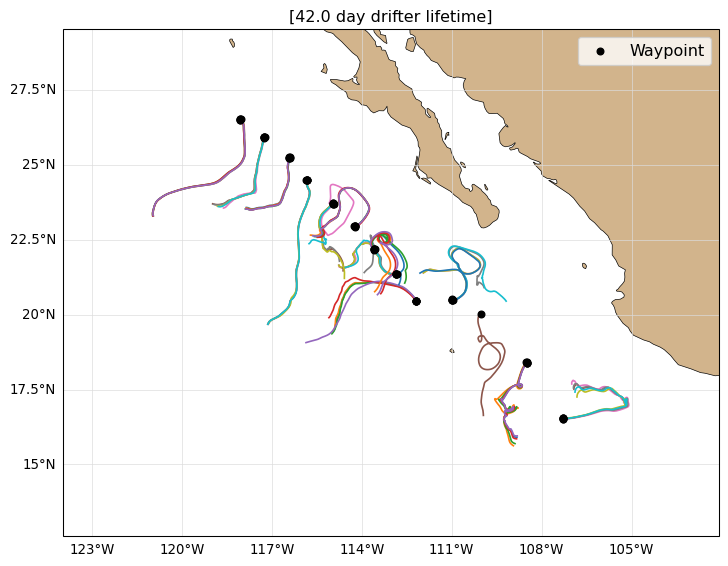

In [61]:
# fig
fig = plt.figure(figsize=(10, 6), dpi=96)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# plot trajectory
for i, traj in enumerate(drifter_ds["trajectory"]):
    # extract trajectory data
    lons = drifter_ds["lon"][:].sel(trajectory=traj).squeeze()
    lats = drifter_ds["lat"][:].sel(trajectory=traj).squeeze()

    # plot
    ax.plot(
        lons,
        lats,
        linestyle="-",
        linewidth=1.25,
        zorder=3,
        transform=ccrs.PlateCarree(),
    )

    # add release location
    MARKERSIZE = 25
    ax.scatter(
        lons[0],
        lats[0],
        marker="o",
        s=MARKERSIZE,
        color="black",
        zorder=4,
        transform=ccrs.PlateCarree(),
        label="Waypoint" if i == 0 else None,  # only label first for legend
    )


# additional map features
latlon_buffer = 3.0  # degrees (adjust this to 'zoom' in/out in the plot)
ax.set_extent(
    [
        drifter_ds.lon.min() - latlon_buffer,
        drifter_ds.lon.max() + latlon_buffer,
        drifter_ds.lat.min() - latlon_buffer,
        drifter_ds.lat.max() + latlon_buffer,
    ],
    crs=ccrs.PlateCarree(),
)
ax.coastlines(linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="tan")
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gainsboro",
    alpha=1.0,
    linestyle="-",
    zorder=0,
)
gl.top_labels = False
gl.right_labels = False

ax.legend(loc="upper right", fontsize=12)

n_days = float(
    (drifter_ds["time"][0].max(skipna=True) - drifter_ds["time"][0].min(skipna=True))
    / np.timedelta64(1, "D")
)
plt.title(f"[{round(n_days, 1)} day drifter lifetime]", fontsize=12)

plt.tight_layout()

### Add temperature data to the trajectories

The VirtualShip drifters will sample sea surface temperature (SST) as they flow throught the ocean. We can add this information to our trajectory plot by colouring the drifter trajectories by the temperature recorded at each time step.

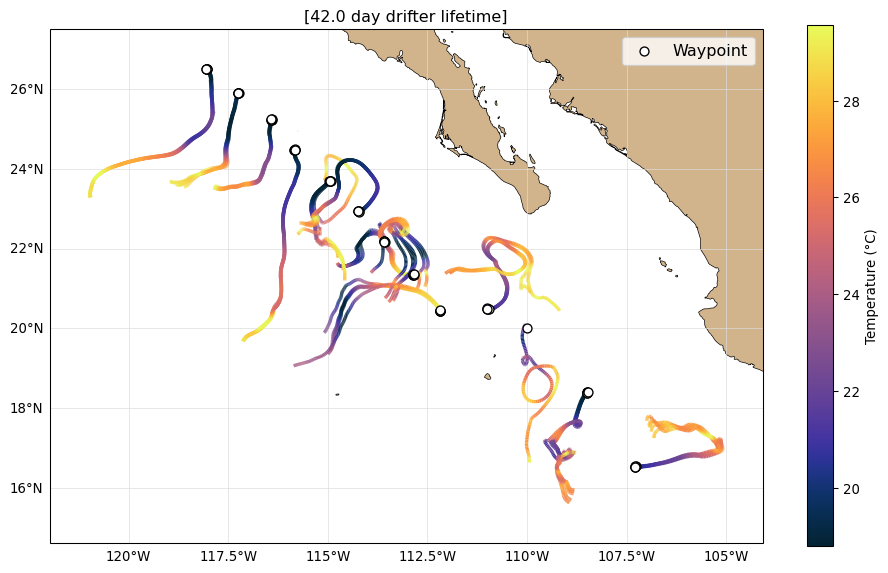

In [62]:
PLOT_VARIABLE = "temperature"

# fig
fig = plt.figure(figsize=(10, 6), dpi=96)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# plot trajectory colored by temperature / salinity
for i, traj in enumerate(drifter_ds["trajectory"]):
    # extract trajectory data
    lons = drifter_ds["lon"][:].sel(trajectory=traj).squeeze().values
    lats = drifter_ds["lat"][:].sel(trajectory=traj).squeeze().values
    var = drifter_ds[PLOT_VARIABLE][:].sel(trajectory=traj).squeeze().values

    # segments for LineCollection
    points = np.array([lons, lats]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # coloured by temperature
    lc = LineCollection(
        segments,
        cmap=cmo.thermal,
        norm=mcolors.Normalize(vmin=np.nanmin(var), vmax=np.nanmax(var)),
        array=var[:-1],
        linewidth=2.5,
        zorder=3,
        transform=ccrs.PlateCarree(),
    )
    ax.add_collection(lc)

    # add release location
    MARKERSIZE = 45
    ax.scatter(
        lons[0],
        lats[0],
        marker="o",
        s=MARKERSIZE,
        color="white",
        edgecolor="black",
        zorder=4,
        transform=ccrs.PlateCarree(),
        label="Waypoint" if i == 0 else None,  # only label first for legend
    )


# additional map features
latlon_buffer = 1.0  # degrees (adjust this to 'zoom' in/out in the plot)
ax.set_extent(
    [
        drifter_ds.lon.min() - latlon_buffer,
        drifter_ds.lon.max() + latlon_buffer,
        drifter_ds.lat.min() - latlon_buffer,
        drifter_ds.lat.max() + latlon_buffer,
    ],
    crs=ccrs.PlateCarree(),
)
ax.coastlines(linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="tan")
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gainsboro",
    alpha=1.0,
    linestyle="-",
    zorder=0,
)
gl.top_labels = False
gl.right_labels = False

# add colorbar
sm = plt.cm.ScalarMappable(
    cmap=cmo.thermal,
    norm=mcolors.Normalize(
        vmin=float(drifter_ds.temperature.min()),
        vmax=float(drifter_ds.temperature.max()),
    ),
)
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", label="Temperature (°C)")

ax.legend(loc="upper right", fontsize=12)

n_days = float(
    (drifter_ds["time"][0].max(skipna=True) - drifter_ds["time"][0].min(skipna=True))
    / np.timedelta64(1, "D")
)
plt.title(f"[{round(n_days, 1)} day drifter lifetime]", fontsize=12)

plt.tight_layout()

## Case study: Interpreting drifter trajectories

<div class="alert alert-block alert-info"> 
<b>**NOTE**:</b> This next section has no code to run and will likely look different from your own results - you will have run your own drifter simulations with different initial positions and times! This is just an example to demonstrate the kinds of drifter flow dynamics questions you can start to think about.
</div>

The Atlantic and Indian Ocean meet around South Africa, and this is one of the most dynamic and energetic regions in the world ocean. The Agulhas retroflection is a region where the Agulhas current retroflects back into the Indian Ocean. This region is known for its strong currents and eddies, and is a region where many drifters have been deployed.

Below is an example of a previous VirtualShip drifter experiment in the Agulhas region, showing the trajectories of 20 virtual drifters launched from a line at 31S between 31E and 32E (see red dots) on the 2 and 21 July 2023, one each day at midnight, simulated forward in time 90 days.



![trajectories](./assets/trajan_drifters.png)

As you see, the drifters all start in the Agulhas Current (red dots at 30S) and most are initially advected southwestwards (although some first move northeastwards). At least two drifters take a path farther offshore, where their trajectories are much more eddying. When the inshore drifters reach approximately 25E, some of them start to circulate in eddies, and their tracks become even more convoluted.

One potentially interesting analysis could be to compare the starting longitude to the final longitude. Do the drifters that start on the inshore side of the Agulhas Current have a higher chance to end up in the Atlantic Ocean (aka Agulhas leakage) than the drifters that start on the offshore side?

![final_vs_start_lon](./assets/initial_vs_final_drifters.png)

How do you interpret this plot? Is it what you expected? 

What other analyses could be interesting to do with this data? Would it be interesting to look at the temperature or salinity that the drifters experience along their trajectories?